In [1]:
import argparse
# standard
import os
import pickle
import random
import time
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from PIL import Image
# imports
# torch and friends
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import os.path as osp
import torchio as tio
import torchvision.utils as vutils
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from torch.utils.data import DataLoader, Dataset
from torchio.transforms.augmentation.intensity.random_bias_field import \
    RandomBiasField
from torchio.transforms.augmentation.intensity.random_noise import RandomNoise
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST, SVHN, FashionMNIST
from torchvision.utils import make_grid
from tqdm import tqdm

import utils.my_trainer as trainer
import utils.train_result as train_result
from dataset import DigitalMonstersDataset, ImageDatasetFromFile
from datasets.dataset import CLASS_MAP, load_data
from metrics.fid_score import calculate_fid_given_dataset
from utils.data_class import BrainDataset

matplotlib.use('Agg')

/home/tomoshi/.pyenv/versions/3.8.13/envs/softintro/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = True #この行をFalseにすると再現性はとれるが、速度が落ちる
    torch.backends.cudnn.deterministic = True
    return
fix_seed(0)

CLASS_MAP = {
    "CN": 0,
    "AD": 1,
    "EMCI": 2,
    "LMCI": 3,
    "MCI": 4,
    "SMC": 5,
}
SEED_VALUE = 0

data = load_data(kinds=["ADNI2","ADNI2-2"], classes=["CN","AD","MCI","EMCI","LMCI","SMC"],size="half",unique=False, blacklist=False)
# classes=["CN","AD","MCI","EMCI","LMCI","SMC"]

pids = []
voxels = np.zeros((len(data), 80, 96, 80))
labels = np.zeros(len(data))
for i in tqdm(range(len(data))):
    pids.append(data[i]["pid"])
    voxels[i] = data[i]["voxel"]
    # voxels[i] = normalize(voxels[i], np.min(voxels[i]), np.max(voxels[i]))
    labels[i] = CLASS_MAP[data[i]["label"]]
pids = np.array(pids)

gss = GroupShuffleSplit(test_size=0.2, random_state=42)
tid, vid = list(gss.split(voxels, groups=pids))[0]
train_voxels = voxels[tid]
val_voxels = voxels[vid]
train_labels = labels[tid]
val_labels = labels[vid]


100%|████████████████████████████████████████████████████████████████████████████████| 4184/4184 [00:14<00:00, 296.30it/s]


In [3]:
train_set = BrainDataset(train_voxels, train_labels)
val_set = BrainDataset(val_voxels, val_labels)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [4]:
class BuildingBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride, bias=False):
        super(BuildingBlock, self).__init__()
        self.res = stride == 1
        self.shortcut = self._shortcut()
        self.relu = nn.ReLU(inplace=True)
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=stride),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(out_ch),
        )

    def _shortcut(self):
        return lambda x: x

    def forward(self, x):
        if self.res:
            shortcut = self.shortcut(x)
            return self.relu(self.block(x) + shortcut)
        else:
            return self.relu(self.block(x))

class UpsampleBuildingkBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride, bias=False):
        super(UpsampleBuildingkBlock, self).__init__()
        self.res = stride == 1
        self.shortcut = self._shortcut()
        self.relu = nn.ReLU(inplace=True)
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=stride),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(out_ch),
        )

    def _shortcut(self):
        return lambda x: x

    def forward(self, x):
        if self.res:
            shortcut = self.shortcut(x)
            return self.relu(self.block(x) + shortcut)
        else:
            return self.relu(self.block(x))

class ResNetEncoder(nn.Module):
    def __init__(self, in_ch, block_setting):
        super(ResNetEncoder, self).__init__()
        self.block_setting = block_setting
        self.in_ch = in_ch
        last = 1
        blocks = [nn.Sequential(
            nn.Conv2d(1, in_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
        )]
        for line in self.block_setting:
            c, n, s = line[0], line[1], line[2]
            for i in range(n):
                stride = s if i == 0 else 1
                blocks.append(nn.Sequential(BuildingBlock(in_ch, c, stride)))
                in_ch = c
        self.inner_ch = in_ch
        self.blocks = nn.Sequential(*blocks)
        self.conv = nn.Sequential(nn.Conv2d(in_ch, last, kernel_size=1, stride=1, bias=True))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.blocks(x)
        return self.conv(h)

class ResNetDecoder(nn.Module):
    def __init__(self, encoder: ResNetEncoder, blocks=None):
        super(ResNetDecoder, self).__init__()
        last = encoder.block_setting[-1][0]
        if blocks is None:
            blocks = [nn.Sequential(
                nn.Conv2d(1, last, 1, 1, bias=True),
                nn.BatchNorm2d(last),
                nn.ReLU(inplace=True),
            )]
        in_ch = last
        for i in range(len(encoder.block_setting)):
            if i == len(encoder.block_setting) - 1:
                nc = encoder.in_ch
            else:
                nc = encoder.block_setting[::-1][i + 1][0]
            c, n, s = encoder.block_setting[::-1][i]
            for j in range(n):
                stride = s if j == n-1 else 1
                c = nc if j == n-1 else c
                blocks.append(nn.Sequential(UpsampleBuildingkBlock(in_ch, c, stride)))
                in_ch = c
        blocks.append(nn.Sequential(
            nn.Conv2d(in_ch, 1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
        ))
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.blocks(x)

class BaseEncoder(nn.Module):
    def __init__(self) -> None:
        super(BaseEncoder, self).__init__()
class BaseDecoder(nn.Module):
    def __init__(self) -> None:
        super(BaseDecoder, self).__init__()

class BaseCAE(nn.Module):
    def __init__(self) -> None:
        super(BaseCAE, self).__init__()
        self.encoder = BaseEncoder()
        self.decoder = BaseDecoder()
    def encode(self, x):
        z = self.encoder(x)
        return z
    def decode(self, z):
        out = self.decoder(z)
        return out
    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out, z

class BaseVAE(nn.Module):
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()
        self.encoder = BaseEncoder()
        self.decoder = BaseDecoder()
    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar
    def decode(self, vec):
        out = self.decoder(vec)
        return out
    def reparameterize(self, mu, logvar) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encode(x)
        vec = self.reparameterize(mu, logvar)
        x_hat = self.decode(vec)
        return x_hat, vec, mu, logvar

class ResNetCAE(BaseCAE):
    def __init__(self, in_ch, block_setting) -> None:
        super(ResNetCAE, self).__init__()
        self.encoder = ResNetEncoder(
            in_ch=in_ch,
            block_setting=block_setting,
        )
        self.decoder = ResNetDecoder(self.encoder)

class VAEResNetEncoder(ResNetEncoder):
    def __init__(self, in_ch, block_setting) -> None:
        super(VAEResNetEncoder, self).__init__(in_ch, block_setting)
        self.mu = nn.Conv2d(self.inner_ch, 1, kernel_size=1, stride=1, bias=True)
        self.var = nn.Conv2d(self.inner_ch, 1, kernel_size=1, stride=1, bias=True)

    def forward(self, x: torch.Tensor):
        h = self.blocks(x)
        mu = self.mu(h)
        var = self.var(h)
        return mu, var
        
class ResNetVAE(BaseVAE):
    def __init__(self, in_ch, block_setting) -> None:
        super(ResNetVAE, self).__init__()
        self.encoder = VAEResNetEncoder(
            in_ch=in_ch,
            block_setting=block_setting,
        )
        self.decoder = ResNetDecoder(self.encoder)

class SoftIntroVAE(nn.Module):
    def __init__(self, in_ch, block_setting, conditional=False):
        super(SoftIntroVAE, self).__init__()
        self.conditional = conditional
        self.encoder = VAEResNetEncoder(in_ch=in_ch, block_setting=block_setting)
        self.decoder = ResNetDecoder(self.encoder)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_re = self.decoder(z)
        return mu, logvar, z, x_re

    # def loss(self, x_re, x, mu, logvar):
    #     re_err = torch.sqrt(torch.mean((x_re - x)**2)) # ==  self.Rmse(x_re, x)
    #     kld = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    #     return re_err + kld

    def sample(self, z, y_cond=None):
        # x.view(-1, 2)
        y = self.decode(z, y_cond=y_cond)
        return y

    def sample_with_noise(self, num_samples=1, device=torch.device("cpu"), y_cond=None):
        z = torch.randn(num_samples, 1, 5, 5).to(device)
        return self.decode(z, y_cond=y_cond)

    def encode(self, x, o_cond=None):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def decode(self, z, y_cond=None):
        y = self.decoder(z)
        return y

In [5]:
def calc_kl(logvar, mu, mu_o=0.0, logvar_o=0.0, reduce='sum'):
    """
    Calculate kl-divergence
    :param logvar: log-variance from the encoder
    :param mu: mean from the encoder
    :param mu_o: negative mean for outliers (hyper-parameter)
    :param logvar_o: negative log-variance for outliers (hyper-parameter)
    :param reduce: type of reduce: 'sum', 'none'
    :return: kld
    """
    if not isinstance(mu_o, torch.Tensor):
        mu_o = torch.tensor(mu_o).to(mu.device)
    if not isinstance(logvar_o, torch.Tensor):
        logvar_o = torch.tensor(logvar_o).to(mu.device)
    kl = -0.5 * (1 + logvar - logvar_o - logvar.exp() / torch.exp(logvar_o) - (mu - mu_o).pow(2) / torch.exp(
        logvar_o)).sum(1)
    if reduce == 'sum':
        kl = torch.sum(kl)
    elif reduce == 'mean':
        kl = torch.mean(kl)
    return kl


def reparameterize(mu, logvar):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variaance of x
    :return z: the sampled latent variable
    """
    device = mu.device
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std


def calc_reconstruction_loss(x, recon_x, loss_type='mse', reduction='sum'):
    """

    :param x: original inputs
    :param recon_x:  reconstruction of the VAE's input
    :param loss_type: "mse", "l1", "bce"
    :param reduction: "sum", "mean", "none"
    :return: recon_loss
    """
    if reduction not in ['sum', 'mean', 'none']:
        raise NotImplementedError
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='none')
        recon_error = recon_error.sum(1)
        if reduction == 'sum':
            recon_error = recon_error.sum()
        elif reduction == 'mean':
            recon_error = recon_error.mean()
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction=reduction)
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction=reduction)
    else:
        raise NotImplementedError
    return recon_error


def str_to_list(x):
    return [int(xi) for xi in x.split(',')]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".png", ".jpeg", ".bmp"])


def record_scalar(writer, scalar_list, scalar_name_list, cur_iter):
    scalar_name_list = scalar_name_list[1:-1].split(',')
    for idx, item in enumerate(scalar_list):
        writer.add_scalar(scalar_name_list[idx].strip(' '), item, cur_iter)


def record_image(writer, image_list, cur_iter, num_rows=8):
    image_to_show = torch.cat(image_list, dim=0)
    writer.add_image('visualization', make_grid(image_to_show, nrow=num_rows), cur_iter)


def load_model(model, pretrained, device):
    weights = torch.load(pretrained, map_location=device)
    model.load_state_dict(weights['model'], strict=False)


def save_checkpoint(model, epoch, iteration, prefix=""):
    model_out_path = "./saves/" +"brain/"+ prefix + "model_epoch_{}_iter_{}.pth".format(epoch, iteration)
    state = {"epoch": epoch, "model": model.state_dict()}
    if not os.path.exists("./saves/brain/"):
        os.makedirs("./saves/brain/")

    torch.save(state, model_out_path)

    print("model checkpoint saved @ {}".format(model_out_path))


In [6]:
import os
import os.path as osp
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets.dataset import load_data#, CLASS_MAP
from sklearn.model_selection import GroupShuffleSplit
import argparse
import csv

import utils.my_trainer as trainer
import utils.train_result as train_result
from utils.data_class import BrainDataset
import torchio as tio
import numpy as np
from PIL import Image

In [7]:
# Function line up input images and output images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


def show_image(image, output):    
    %matplotlib inline

    fig = plt.figure(figsize=(18,5),dpi=600)
    X, Y = 2, 6
    
    for i in range(6):
        imgplot = i + 1
        ax1 = fig.add_subplot(X, Y, imgplot)
        # ax1.set_title("original"+str(imgplot), fontsize=12)
        # img = np.flip(image[i].numpy().reshape(80, 80, 80).transpose(1,2,0)[50],0)
        img = np.flip(image[i+46].T.numpy().reshape(80,80))
        # img = np.flip(image[i].T.numpy().reshape(80,80))
        plt.axis("off")
        plt.imshow(img, cmap="gray")
        plt.tick_params(labelsize=8)
        
        
        ax2 = fig.add_subplot(X, Y, imgplot+Y)
        # ax2.set_title("output"+str(imgplot), fontsize=12) 
        # out = np.flip(output[i].numpy().reshape(80, 80, 80).transpose(1,2,0)[50],0)
        out = np.flip(output[i+46].T.numpy().reshape(80,80))
        # out = np.flip(output[i].T.numpy().reshape(80,80))
        plt.axis("off")
        plt.imshow(out, cmap="gray")
        ax_pos = ax2.get_position()
        mse_value = round(np.sqrt(mean_squared_error(img, out)), 3)
        ssim_value = round(ssim(img, out), 3)
        # fig.text(ax_pos.x1 - 0.065, ax_pos.y1 - 0.4, " rmse: " + str(mse_value), size=12)
        # fig.text(ax_pos.x1 - 0.065, ax_pos.y1 - 0.45, "ssim: " + str(ssim_value), size=12)
        plt.tick_params(labelsize=8)
        # plt.savefig("output_1.pdf",bbox_inches="tight",pad_inches=0)
    #fig.tight_layout()
    # plt.savefig("miss_reconst.pdf",bbox_inches="tight",pad_inches=0)
    plt.show()

In [8]:
import cv2
import matplotlib.pyplot as plt
def calc_ssim(image, output):
    mse_sum = 0
    ssim_sum = 0
    for i in range(len(image)):
        # img = np.flip(image[i].numpy().reshape(80, 80, 80).transpose(1,2,0)[50],0)
        # out = np.flip(output[i].numpy().reshape(80, 80, 80).transpose(1,2,0)[50],0)
        img = np.flip(image[i].numpy().reshape(80, 80))
        out = np.flip(output[i].numpy().reshape(80, 80))

        mse_value = mean_squared_error(img, out)
        ssim_value = ssim(img, out)

        mse_sum += mse_value
        ssim_sum += ssim_value
    print(len(image))
    
    return np.sqrt(mse_sum / len(image)), ssim_sum / len(image)

In [9]:
def parser():
    parser = argparse.ArgumentParser(description="example")
    parser.add_argument("--batch_size", type=int, default=8)
    parser.add_argument("--epoch", type=int, default=200)
    parser.add_argument("--lr", type=float, default=2e-4)
    parser.add_argument("--log", type=str, default="output")
    parser.add_argument("--n_train", type=float, default=0.8)
    parser.add_argument("--train_or_loadnet", type=str, default="loadnet")    # train or loadnet
    parser.add_argument("--model", type=str, default="VAE")     # VAE or CAE
    args = parser.parse_args(args=[])
    return args

In [10]:
torch.manual_seed(0)
args = parser()

device = torch.device("cuda:1" if torch.cuda.is_available() and True else "cpu")
print("device:", device)    

device: cuda:1


In [13]:
train_loader = DataLoader(train_set, batch_size=1, shuffle=True,
                                   num_workers=28,worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False,
                                   num_workers=28,worker_init_fn=seed_worker,generator=g)

VAE


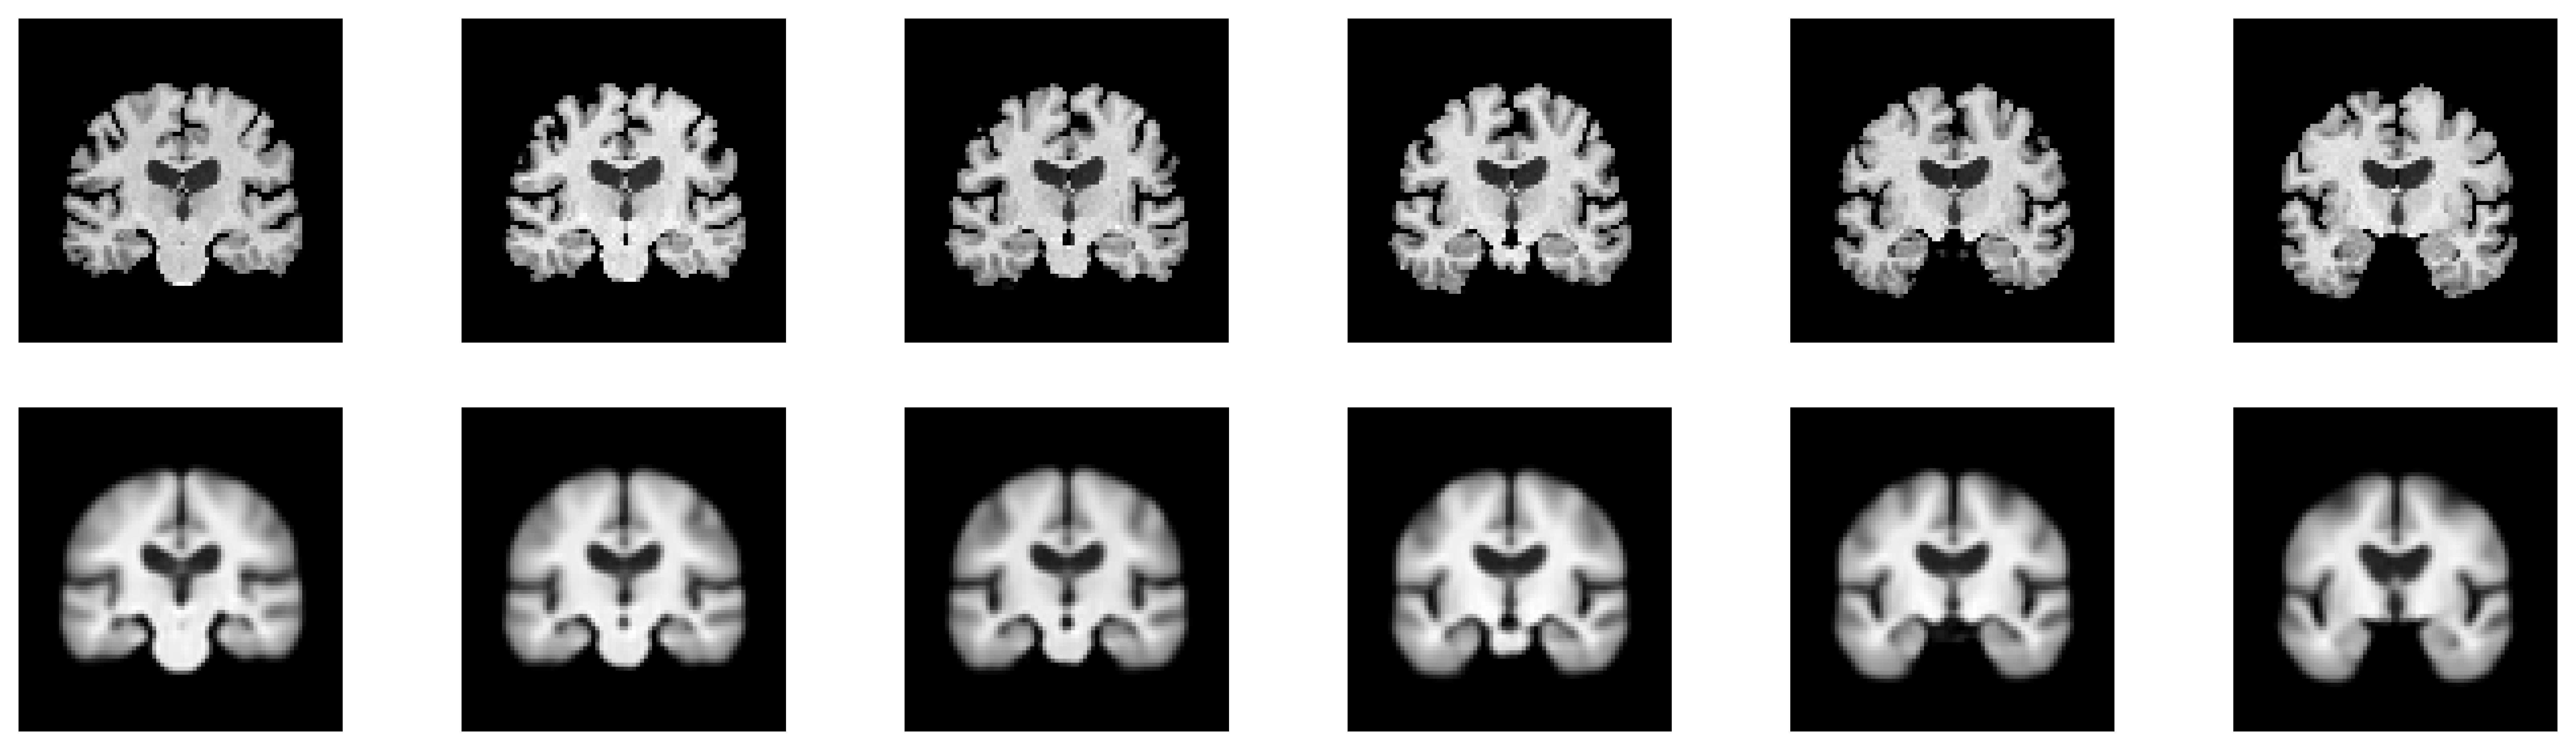

96
0.08717824155698899 0.8677855986752512


In [14]:
if args.model == "VAE":
    print("VAE")
    log_path = ".saves/" + "brain"

    os.makedirs(log_path, exist_ok=True)
    
    net = ResNetVAE(12, [[12,1,2],[24,1,2],[32,2,2],[48,2,2]])
    net.load_state_dict(torch.load("logs/output_vae/vae_weight.pth"))
    val_loader_iter = iter(val_loader)
    image, _ = next(val_loader_iter)
    # input_image = torch.zeros((len(image)*80,1,80,80))
    input_image = torch.zeros((len(image)*96,1,80,80))
    for i in range(len(image)):
        for j in range(96):
            input_image[i*96+j] = image[i,:,:,j,:]
    # for i in range(len(image)):
    #     for j in range(80):
    #         input_image[i*80+j] = image[i,:,:,j+8,:]
    image = input_image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        # _,_,_,output = net.forward(image)
        output,_,_,_= net.forward(image)

    image = image.cpu()
    output = output.cpu()

    show_image(image, output)
    mse, ssim_score = calc_ssim(image, output)
    print(mse, ssim_score)
    # pil_img = Image.fromarray(np.flip(output[0].numpy().reshape(80, 80, 80).transpose(1,2,0)[50],0) * 255)
    # pil_img = pil_img.convert("L")
    #pil_img.save(log_path+"img/vae_output_img.jpg")


elif args.model == "CAE":
    print("CAE")
    log_path = "./logs/" + args.log + "_cae/"
    os.makedirs(log_path, exist_ok=True)

    net = models.Cae()
    # net = models.CAE()
    # net = torch.nn.DataParallel(net, device_ids=[0,1])
    net.load_state_dict(torch.load(log_path+'cae_weight2.pth'))

    val_loader_iter = iter(val_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output = net(image)

    image = image.cpu()
    output = output.cpu()

    show_image(image, output)